In [25]:
import pandas as pd  # data processing, CSV file I/O
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import keras_metrics as km
import seaborn as sns

# make a plot outputs appear and be stored within the notebook
%matplotlib inline

print("Complete")

Complete


In [26]:
LETTER_NAMES = {
    1: "alif",
    10: "ra",
    11: "zay",
    12: "sin",
    13: "shin",
    14: "sad",
    15: "dad",
    16: "da",
    17: "za",
    18: "ayn",
    19: "gayn",
    2: "ba",
    20: "fa",
    21: "qaf",
    22: "kaf",
    23: "lam",
    24: "mim",
    25: "non",
    26: "ha",
    27: "waw",
    28: "ya",
    29: "hamza",
    3: "ta",
    4: "tha",
    5: "gim",
    6: "ha",
    7: "kha",
    8: "dal",
    9: "thal"
}

In [27]:
x_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

In [28]:
print(x_train.columns)
print(y_train.columns)
assert len(x_train) == len(y_train)

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel1014', 'pixel1015', 'pixel1016', 'pixel1017', 'pixel1018',
       'pixel1019', 'pixel1020', 'pixel1021', 'pixel1022', 'pixel1023'],
      dtype='object', length=1024)
Index(['label'], dtype='object')


In [29]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Columns: 1024 entries, pixel0 to pixel1023
dtypes: int64(1024)
memory usage: 296.4 MB


In [30]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   37933 non-null  int64
dtypes: int64(1)
memory usage: 296.5 KB


### Distributions

<AxesSubplot:>

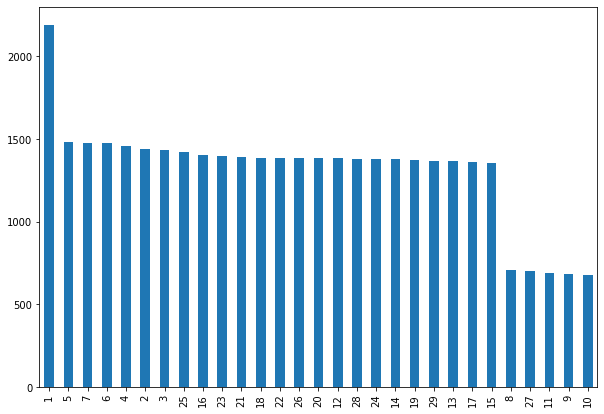

In [31]:
plt.figure(figsize=(10,7))
y_train['label'].value_counts().plot(kind="bar")

In [32]:
max([x_train[column].max() for column in x_train.columns] )

255

So each pixel takes value 0-255

### Changing data format to compatible with tf training

Shuffling

In [33]:
idx = np.random.permutation(x_train.index)
x_train = x_train.reindex(idx)
y_train = y_train.reindex(idx)

In [34]:
def convert_to_tensor(x_data):
    rows_num = len(x_data)
    new_shape = [rows_num, 32, 32, 1]
    print(new_shape)
    x_data_tf = x_data.values.reshape(new_shape)
    x_data_tf = tf.convert_to_tensor(x_data_tf)
    x_data_tf = x_data_tf / 255 # normalisation from 0 - 255 to 0 - 1
    return x_data_tf

In [35]:
x_train_tf = convert_to_tensor(x_train)
x_train_tf

[37933, 32, 32, 1]


<tf.Tensor: shape=(37933, 32, 32, 1), dtype=float64, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
  

In [36]:
y_train_tf = y_train - 1
y_train_tf

,label
4036,2
4885,2
13013,9
26344,20
2998,1
...,...
25418,19
33841,25
139,0
7132,4


### Test data
For assessing accuracy, loss, etc

In [37]:
x_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

In [38]:
x_test_tf = convert_to_tensor(x_test)
y_test_tf = y_test - 1
y_test_tf

[9501, 32, 32, 1]


,label
0,0
1,0
2,0
3,0
4,0
...,...
9496,28
9497,28
9498,28
9499,28


### TF model

In [39]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
# NUMBER_OF_LAYERS = 7
NUMBER_OF_CONV2D = 5

In [81]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 1)))
    for i in range(NUMBER_OF_CONV2D):
        model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('units_0', min_value=5, max_value=128, step=5)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))

    model.add(tf.keras.layers.Reshape((hp_units,1)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
    model.add(tf.keras.layers.Flatten())

    # for i in range(1, NUMBER_OF_LAYERS + 1):
    #     # Tune the number of units in the first Dense layer
    #     # Choose an optimal value between 5-1024
    #     hp_units = hp.Int(f'units_{i}', min_value=5, max_value=2048//i, step=5)
    #     model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    #     model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Dense(29, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

    return model

In [82]:
tuner = kt.Hyperband(model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3    ,
    project_name='hyperparams')

INFO:tensorflow:Reloading Oracle from existing project .\hyperparams\oracle.json
INFO:tensorflow:Reloading Tuner from .\hyperparams\tuner0.json


In [83]:
tuner.search(x_train_tf, y_train_tf, epochs=50, validation_split=0.1, shuffle=True, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [84]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
# for i in range(NUMBER_OF_LAYERS + 1):
    # print(f"Layer {i}: {best_hps.get(f'units_{i}')}")

In [85]:
history = model.fit(x_train_tf, y_train_tf, epochs=300, shuffle=True, validation_split=0.1, callbacks=[stop_early])

Epoch 1/300
1067/1067 [==============================] - 96s 87ms/step - loss: 2.1898 - accuracy: 0.3217 - val_loss: 1.2603 - val_accuracy: 0.5778
Epoch 2/300
1067/1067 [==============================] - 91s 85ms/step - loss: 1.0840 - accuracy: 0.6381 - val_loss: 0.9872 - val_accuracy: 0.6943
Epoch 3/300
1067/1067 [==============================] - 92s 86ms/step - loss: 0.8111 - accuracy: 0.7384 - val_loss: 0.7270 - val_accuracy: 0.7686
Epoch 4/300
1067/1067 [==============================] - 92s 86ms/step - loss: 0.6778 - accuracy: 0.7798 - val_loss: 0.6947 - val_accuracy: 0.7783
Epoch 5/300
1067/1067 [==============================] - 92s 86ms/step - loss: 0.5795 - accuracy: 0.8131 - val_loss: 0.7233 - val_accuracy: 0.7662
Epoch 6/300
1067/1067 [==============================] - 93s 87ms/step - loss: 0.5211 - accuracy: 0.8341 - val_loss: 0.6305 - val_accuracy: 0.8013
Epoch 7/300
1067/1067 [==============================] - 93s 87ms/step - loss: 0.4781 - accuracy: 0.8450 - val_loss: 0

In [86]:
model.summary()

In [91]:
model.save('new_best')

INFO:tensorflow:Assets written to: new_best\assets


INFO:tensorflow:Assets written to: new_best\assets


In [40]:
model = tf.keras.models.load_model('new_best')

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy',
        tf.keras.metrics.SparseCategoricalCrossentropy(),
        km.sparse_categorical_precision(),
        km.sparse_categorical_recall(),
        km.sparse_categorical_f1_score()])

In [42]:
result = model.evaluate(x_test_tf,  y_test_tf, verbose=2)

d:\Programs\Python3_9_2\lib\site-packages\keras_metrics\metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


297/297 - 46s - loss: 0.5458 - accuracy: 0.8377 - sparse_categorical_crossentropy: 0.5458 - precision: 0.9930 - recall: 0.9707 - f1_score: 0.9817 - 46s/epoch - 155ms/step


In [43]:
dict(zip(model.metrics_names, result))

{'loss': 0.545817494392395,
 'accuracy': 0.8377013206481934,
 'sparse_categorical_crossentropy': 0.545817494392395,
 'precision': 0.993037760257721,
 'recall': 0.9707184433937073,
 'f1_score': 0.9817465543746948}

In [44]:
pred = np.argmax(model.predict(x_test_tf), axis=1)

In [55]:
from sklearn.metrics import classification_report
sorted_dict = dict(sorted(LETTER_NAMES.items()))
print(classification_report(y_test_tf, pred, target_names=sorted_dict.values()))

              precision    recall  f1-score   support

        alif       0.98      0.97      0.97       549
          ba       0.92      0.90      0.91       360
          ta       0.82      0.87      0.84       360
         tha       0.90      0.74      0.81       366
         gim       0.89      0.86      0.87       372
          ha       0.82      0.68      0.74       369
         kha       0.91      0.74      0.82       370
         dal       0.77      0.71      0.74       178
        thal       0.72      0.73      0.72       171
          ra       0.87      0.89      0.88       170
         zay       0.85      0.89      0.87       172
         sin       0.87      0.97      0.92       346
        shin       0.79      0.93      0.85       342
         sad       0.81      0.85      0.83       345
         dad       0.68      0.91      0.78       339
          da       0.87      0.89      0.88       351
          za       0.87      0.90      0.88       342
         ayn       0.73    

Text(240.0, 0.5, 'Actual')

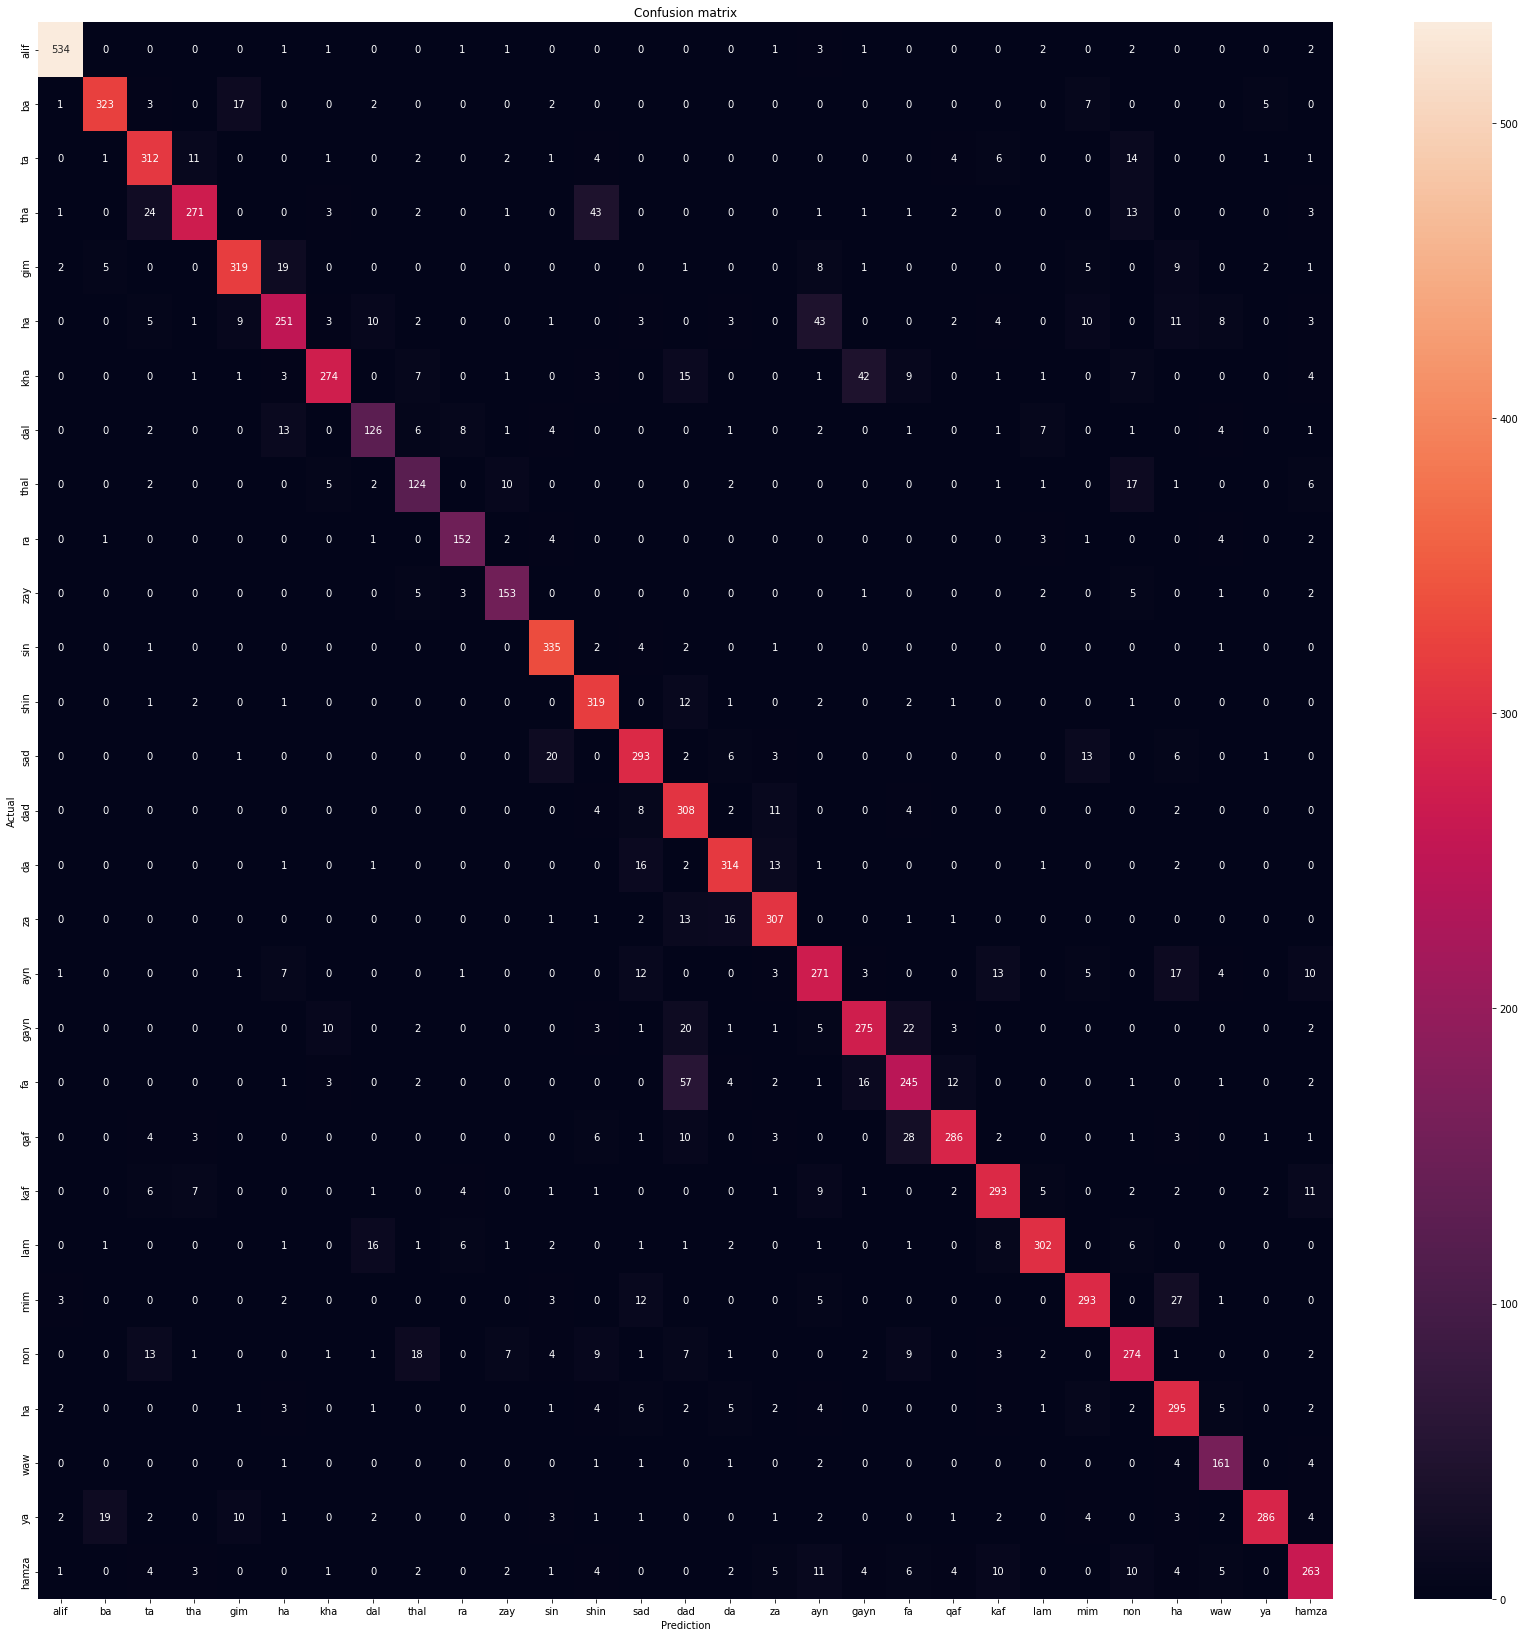

In [47]:
cm = tf.math.confusion_matrix(labels=y_test_tf, predictions=pred, num_classes=29)
plt.figure(figsize = (29, 29))
sns.heatmap(cm, annot = True, fmt='g', xticklabels=sorted_dict.values(), yticklabels=sorted_dict.values())
plt.title("Confusion matrix")
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [56]:
accuracy = model.history['accuracy']
val_accuracy = model.history['val_accuracy']
loss = model.history['loss']
val_loss = model.history['val_loss']

In [ ]:
epochs = range(len(accuracy))
plt.figure(figsize=(15,10)) 
plt.plot(epochs, accuracy, 'bo',  label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
plt.figure(figsize=(15,10)) 
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()